## Digit recognision using MNIST dataset of digits images

The goal is to correctly identify digits from a dataset of tens of thousands of handwritten images.
The data files train.csv and test.csv contain gray-scale images of hand-drawn digits, from zero through nine.

We will use Sequential Convolutional Neural Network for digits recognition.

### Import the libraries

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from tensorflow.python import keras
import tensorflow
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Flatten, Conv2D, Dropout
from tensorflow.python.keras.optimizers import RMSprop
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
train = pd.read_csv('../data/train.csv')
test = pd.read_csv('../data/test.csv')

In [3]:
train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


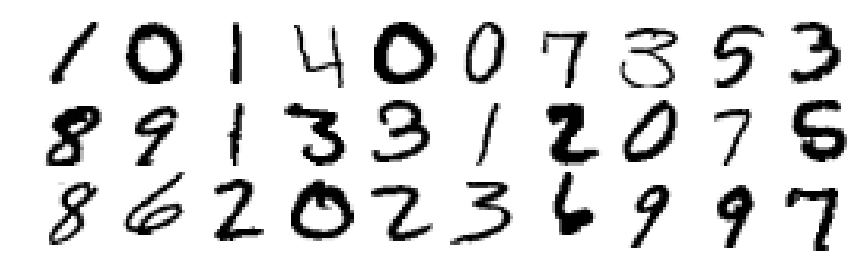

In [4]:
plt.figure(figsize=(15,4.5))
for i in range(30):  
    plt.subplot(3, 10, i+1)
    plt.imshow(train.values[i,1:].reshape((28,28)),cmap=plt.cm.binary)
    plt.axis('off')
plt.subplots_adjust(wspace=-0.1, hspace=-0.1)
plt.show()

In [5]:
test.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


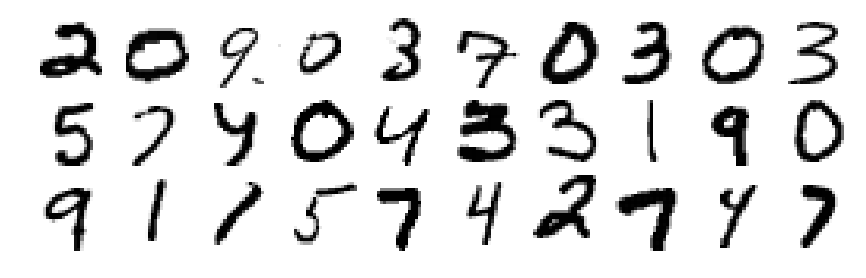

In [6]:
plt.figure(figsize=(15,4.5))
for i in range(30):  
    plt.subplot(3, 10, i+1)
    plt.imshow(test.values[i,:].reshape((28,28)),cmap=plt.cm.binary)
    plt.axis('off')
plt.subplots_adjust(wspace=-0.1, hspace=-0.1)
plt.show()

Each image is 28 pixels in height and 28 pixels in width, for a total of 784 pixels in total. Each pixel has a single pixel-value associated with it, indicating the lightness or darkness of that pixel, with higher numbers meaning darker. This pixel-value is an integer between 0 and 255, inclusive.

The training data set, (train.csv), has 785 columns. The first column, called "label", is the digit that was drawn by the user. The rest of the columns contain the pixel-values of the associated image.

In [7]:
img_rows, img_cols = 28, 28
num_classes = 10

In [8]:
def data_prep(train,test, num_classes):
    out_y = tensorflow.keras.utils.to_categorical(train.label, num_classes)

    num_images = train.shape[0]
    x_as_array = train.values[:,1:]
    x_shaped_array = x_as_array.reshape(num_images, img_rows, img_cols, 1)
    # Data Normalization
    out_x = x_shaped_array / 255

    x_test_shaped_array = test.values[:,:].reshape(test.shape[0], img_rows, img_cols, 1)
    # Data Normalization
    out_x = x_shaped_array / 255
    out_x_test = x_test_shaped_array / 255
    
    
    return out_x, out_y,out_x_test

In [9]:
x, y, xtest = data_prep(train,test, 10)

In [10]:
X_train, X_test, y_train, y_test = train_test_split(x,y,test_size = 0.2, random_state = 42)

### Check for missing data

In [11]:
print("The train set has {} missing value".format(train.isnull().any().sum()))
print("The test set has {} missing value".format(test.isnull().any().sum()))

The train set has 0 missing value
The test set has 0 missing value


### Visualization

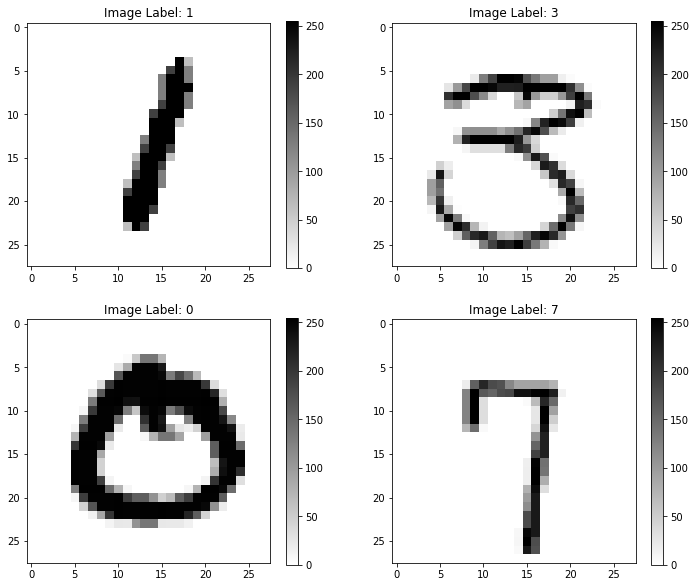

In [12]:
plt.subplots(2,2,figsize = (12,10))
pics = [7,23,50,79]
for i in range(len(pics)):
    plt.subplot(2,2,i+1)
    image_array = (
    np.array(
        train.loc[pics[i-1], "pixel0":]
    )
    .reshape((28,28))
              )
    digit_img = plt.imshow(image_array, cmap=plt.cm.binary)
    plt.colorbar(digit_img)
    plt.title("Image Label: {}".format(train.loc[pics[i-1], "label"]))


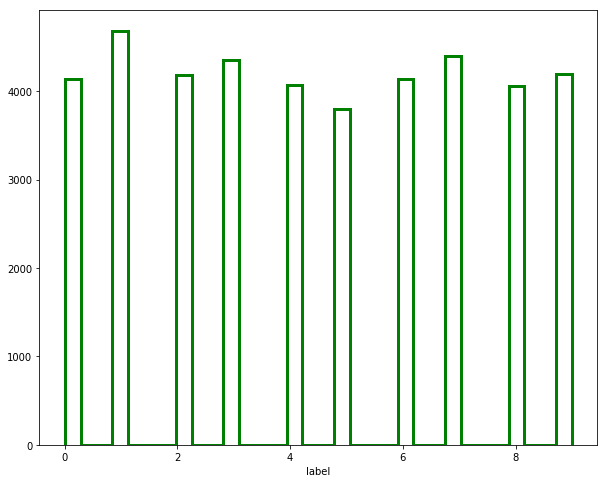

In [13]:
plt.subplots(1,1, figsize=(10,8))
sns.distplot(train.label,kde = False,rug_kws={"color": "g"},
             kde_kws={"color": "k", "lw": 3, "label": "KDE"},
             hist_kws={"histtype": "step", "linewidth": 3,"alpha": 1,
                       "color": "g"});

### Build the model (CNN)

In [14]:
model = Sequential()
model.add(Conv2D(30, kernel_size=(3, 3),
                 strides=2,
                 activation='relu',
                 input_shape=(img_rows, img_cols, 1)))
model.add(Dropout(0.25)) #to combat overfitting
model.add(Conv2D(30, kernel_size=(3, 3), strides=2, activation='relu'))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

In [15]:
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer='adam',
              metrics=['accuracy'])

In [16]:
model_history = model.fit(x,y,batch_size=128,
                          epochs=20,
                          shuffle=True,
                          validation_split = 0.2
                          , verbose=0)

In [17]:
#model_history.history

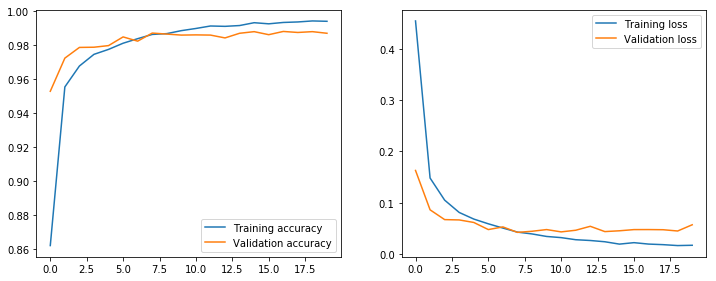

In [18]:
plt.subplots(1,2,figsize = (12,10))
plt.subplot(2,2,1)
plt.plot(model_history.history['accuracy'],label = 'Training accuracy')
plt.plot(model_history.history['val_accuracy'],label = 'Validation accuracy')
plt.legend()
plt.subplot(2,2,2)
plt.plot(model_history.history['loss'],label = 'Training loss')
plt.plot(model_history.history['val_loss'],label = 'Validation loss')
plt.legend()

In [19]:
predictions = model.predict(xtest)

In [20]:
predictions_test = []

for i in predictions:
    predictions_test.append(np.argmax(i))

In [21]:
test['label'] = predictions_test

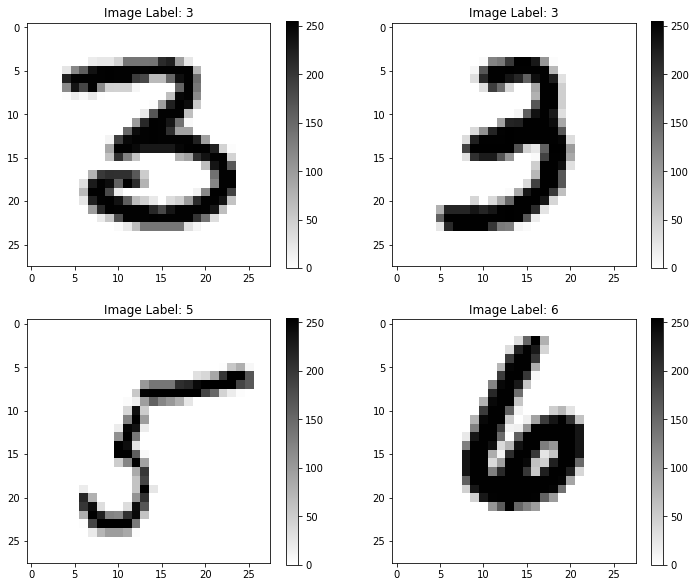

In [22]:
plt.subplots(2,2,figsize = (12,10))
pics = [7,23,50,79]
for i in range(len(pics)):
    plt.subplot(2,2,i+1)
    image_array = (
    np.array(
        test.loc[pics[i-1], "pixel0":"pixel783"]
    )
    .reshape((28,28))
              )
    digit_img = plt.imshow(image_array, cmap=plt.cm.binary)
    plt.colorbar(digit_img)
    plt.title("Image Label: {}".format(test.loc[pics[i-1], "label"]))

### Data augmentation

In [23]:
data = ImageDataGenerator(
    featurewise_center=False,  
        samplewise_center=False, 
        featurewise_std_normalization=False,  
        samplewise_std_normalization=False,  
        zca_whitening=False,  
        rotation_range=10, 
        zoom_range = 0.1, 
        width_shift_range=0.1, 
        height_shift_range=0.1,  
        horizontal_flip=False,  
        vertical_flip=False
)
data.fit(X_train)

In [24]:
model_history2 = model.fit_generator(data.flow(X_train, y_train, batch_size = 80),
                                    epochs=20,
                                    validation_data=(X_test,y_test),
                                    )

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/20
420/420 [==============================] - 11s 26ms/step - loss: 0.2167 - accuracy: 0.9338 - val_loss: 0.0261 - val_accuracy: 0.9921
Epoch 2/20
420/420 [==============================] - 9s 22ms/step - loss: 0.1234 - accuracy: 0.9630 - val_loss: 0.0232 - val_accuracy: 0.9931
Epoch 3/20
420/420 [==============================] - 9s 22ms/step - loss: 0.1090 - accuracy: 0.9659 - val_loss: 0.0236 - val_accuracy: 0.9926
Epoch 4/20
420/420 [==============================] - 14s 32ms/step - loss: 0.0921 - accuracy: 0.9711 - val_loss: 0.0200 - val_accuracy: 0.9938
Epoch 5/20
420/420 [==============================] - 11s 26ms/step - loss: 0.0846 - accuracy: 0.9742 - val_loss: 0.0208 - val_accuracy: 0.9926
Epoch 6/20
420/420 [==============================] - 10s 24ms/step - loss: 0.0817 - accuracy: 0.9754 - val_loss: 0.0266 - val_accuracy: 0.9912
Epoch 7/20
420/420 [==============================] - 10s 23ms

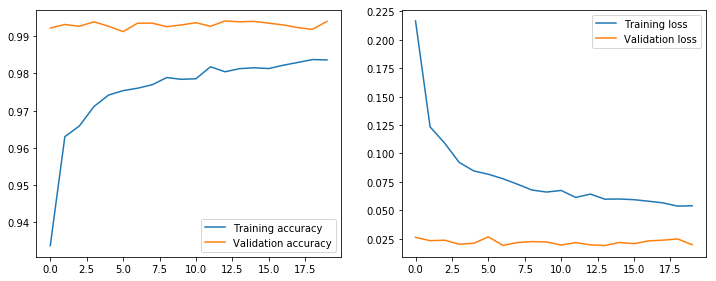

In [25]:
plt.subplots(1,2,figsize = (12,10))
plt.subplot(2,2,1)
plt.plot(model_history2.history['accuracy'],label = 'Training accuracy')
plt.plot(model_history2.history['val_accuracy'],label = 'Validation accuracy')
plt.legend()
plt.subplot(2,2,2)
plt.plot(model_history2.history['loss'],label = 'Training loss')
plt.plot(model_history2.history['val_loss'],label = 'Validation loss')
plt.legend()

In [26]:
preds = model.predict(X_test)

In [27]:
y_pred_classes = np.argmax(preds,axis = 1) 

In [28]:
y_real = np.argmax(y_test, axis = 1)

In [29]:
confusion_mtx = confusion_matrix(y_real, y_pred_classes)

In [30]:
confusion_mtx

array([[813,   0,   1,   0,   0,   0,   0,   0,   1,   1],
       [  1, 904,   0,   0,   0,   0,   1,   3,   0,   0],
       [  0,   1, 842,   1,   0,   0,   0,   0,   2,   0],
       [  0,   0,   1, 933,   0,   1,   0,   1,   0,   1],
       [  0,   0,   0,   0, 828,   0,   2,   2,   1,   6],
       [  0,   0,   0,   1,   0, 699,   1,   0,   1,   0],
       [  2,   0,   0,   0,   0,   0, 782,   0,   1,   0],
       [  0,   1,   1,   0,   1,   0,   0, 889,   0,   1],
       [  0,   1,   0,   2,   0,   3,   0,   1, 827,   1],
       [  0,   0,   0,   1,   2,   1,   0,   1,   1, 832]])